In [1]:
library(igraph)


Attaching package: ‘igraph’


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union




- To build the asymmetric Similarity Matrix, I just build two different Item Matrices and multiply them, in place of multiplying the Item Matrix for itself

In [2]:
#####################################################################
# DOCUMENTATION
#####################################################################
# NN: Length of each item. Each item is a vector of length NN filled with 0 and 1
# ff: probability that each element of an item is 1. Of course 1-ff is the probability that is 0
# LL: Number of items to be recalled in a recalling experiment
# KK: Recalled items
#####################################################################

In [3]:
# *******************************************************************************************************
# Builds ONE item of NN elements with probability ff that each element is 1
# *******************************************************************************************************
Build_Item <- function(NN,ff){
    return(sample(0:1,NN,replace=TRUE,prob=c(1-ff,ff)))
}

# *******************************************************************************************************
# Builds a (LL x NN) matrix containing LL items of length NN. Still ff is the prob
# *******************************************************************************************************
Build_Item_Matrix <- function(NN,LL,ff){
    return(matrix(sample(0:1,NN*LL,replace=TRUE,prob=c(1-ff,ff)),nrow=LL,ncol=NN,byrow=TRUE))
}

# *******************************************************************************************************
# Calculates the Overlap between two items. It is a scalar product
# *******************************************************************************************************
Overlap <- function(x,y){
    return(x %*% y)
}

# *******************************************************************************************************
# Returns a (LL x LL) symmetric matrix, whose elements represents overlaps.
#     first it generates LL items of length NN with prob ff. Then it calculates all the overlaps 
#     between its elements and put them in the matrix. If diagonal=FALSE the self-overlaps are
#     put to 0.
# *******************************************************************************************************
Build_Symmetric_Similarity_Matrix <- function(NN,LL,ff,diagonal){
    x <- Build_Item_Matrix(NN,LL,ff)
    SM <- x %*% t(x)
    if(!diagonal){
        diag(SM) <- 0
    }
    return(SM)
}

# *******************************************************************************************************
# Returns a (LL x LL) symmetric matrix, whose elements represents overlaps.
#     first it generates TWO*LL items of length NN with prob ff, to be put in TWO different item matrices.
#     Then it calculates all the overlaps between the elements of these 2 matrices and put them in the matrix. 
#     If diagonal=FALSE the self-overlaps are put to 0.
# *******************************************************************************************************
Build_Asymmetric_Similarity_Matrix <- function(NN,LL,ff,diagonal){
    x <- Build_Item_Matrix(NN,LL,ff)
    y <- Build_Item_Matrix(NN,LL,ff)
    ASM <- x %*% t(y)
    if(!diagonal){
        diag(ASM) <- 0
    }
    return(ASM)
}

# **********************************************************************************************************
# Returns a (LL x LL) symmetric matrix with 0 elements on the diagonal. The other elements are integer 
# sampled from start to end
# **********************************************************************************************************
old_SAMPLE_Simmetric_Matrix <- function(start,end,LL){
    if(start==0){
        warning('WARNING: You have chosen start=0')
    }
    vec = sample(start:end,LL*(LL-1)/2,replace=TRUE)
    mat <- matrix(0,nrow=LL,ncol=LL)
    mat[lower.tri(mat)] <- vec
    mat <- t(mat)
    mat[lower.tri(mat)] <- vec
    return(mat)
}

SAMPLE_Simmetric_Matrix <- function(LL){
    vec = runif(LL*(LL-1)/2)
    mat <- matrix(0,nrow=LL,ncol=LL)
    mat[lower.tri(mat)] <- vec
    mat <- t(mat)
    mat[lower.tri(mat)] <- vec
    return(mat)
}

In [171]:
## ************************************************************************************************************
# Inputs: a similarity matrix, either symmetric or asymmetric, and the starting item.
# Starts with starts_item. The next recalled item will be the one with the maximum overlap, i.e. the item
# corrsponding to the maximum value of the start_item row of that matrix. All the reaclled items are
# saved in the Recalled_Items vector. The process is repeated until an element is recalled twice. Then a vector
# containing all the recalled items, each one once, is returned
## ************************************************************************************************************
Simple_Recall_Process <- function(Similarity_Matrix,start_item){
    diag(Similarity_Matrix) <- 0                                       #fundamental to not have self-overlaps
    max_vector = apply(Similarity_Matrix,FUN='which.max',MARGIN=1)
    
    Recalled_Items <- start_item
    next_item <- max_vector[tail(Recalled_Items,1)]
    Recalled_Items <- c(Recalled_Items,next_item)

    while(!any((tail(Recalled_Items,1)==Recalled_Items[1:(length(Recalled_Items)-1)]))){
        next_item <- max_vector[tail(Recalled_Items,1)]
        Recalled_Items <- c(Recalled_Items,next_item)
    }

    Recalled_Items <- Recalled_Items[-length(Recalled_Items)]
    
    return(Recalled_Items)
}

## ************************************************************************************************************
# Starts as the Simple_Recall_Process. Then are calculated the max_vector and the second_max_vector, containing
# respectively the element with the maximum overlap and the element with the second max overlap for each row.
# Then it is build the (2 x LL) happened_transitions matrix, full of zeros. When a transition of the
# 'first type' happens TO the element ii, then the element ii of the FIRST row of this matrix is set to 1.
# Exactly the same with the second row, with the transitions of the SECOND type.
# Loop. Next item is calculated using max_vector, but if it is exactly the previous item of the recalled list,
# then I calculated next item using max_second_vector. For each happened transition, both of the 1st or of the
# 2nd type, I put +1 in the happened_transition matrix. As soon as the happened_transition matrix contains a 2,
# then this means that I have entered in a loop, and the process stops.
## ************************************************************************************************************
Double_Recall_Process <- function(Similarity_Matrix,start_item){
    
    diag(Similarity_Matrix) <- 0                                       #fundamental to not have self-overlaps
    
    # build max_vector and also max_second_vector
    max_vector = apply(Similarity_Matrix,FUN='which.max',MARGIN=1)
    copy = t(Similarity_Matrix)
    copy[max_vector+seq(0,nrow(copy)**2-nrow(copy),nrow(copy))] = 0    #I leave all the maximum
    copy = t(copy)
    max_second_vector = apply(copy,FUN='which.max',MARGIN=1)
    
    # keep tracked, by putting zeros, happened transitions
    happened_transitions = matrix(0,nrow=2,ncol=ncol(Similarity_Matrix))
    
    # first iteration
    Recalled_Items <- start_item
    next_item <- max_vector[tail(Recalled_Items,1)]
    happened_transitions[1,tail(Recalled_Items,1)] <- happened_transitions[1,tail(Recalled_Items,1)] + 1
    Recalled_Items <- c(Recalled_Items,next_item)
   
    # A transition has happened twice <-> one element of this matrix is =2
    while(all(happened_transitions!=2)){
        next_item <- max_vector[tail(Recalled_Items,1)]
        if(next_item==Recalled_Items[length(Recalled_Items)-1]){    #if I had to come back, I go to 2nd max
            next_item <- max_second_vector[tail(Recalled_Items,1)]
            happened_transitions[2,tail(Recalled_Items,1)] <- happened_transitions[2,tail(Recalled_Items,1)] + 1
            #ii = ii + 1
        }else{
            happened_transitions[1,tail(Recalled_Items,1)] <- happened_transitions[1,tail(Recalled_Items,1)] + 1
        }
        Recalled_Items <- c(Recalled_Items,next_item)
    }
    #print(Recalled_Items)
    return(unique(Recalled_Items)) #unique is needed, the extra transitions are contained in the vec andmustbe left
}

##########################################################################################################
##########################################################################################################
My_New_Process <- function(Similarity_Matrix, start_item,pp){
     if(pp>1 | pp<0){
         warning('ERROR: pp must be between 0 and 1')
     }
     diag(Similarity_Matrix) <- 0                                       #fundamental to not have self-overlaps
    
    # build max_vector and also max_second_vector
    max_vector = apply(Similarity_Matrix,FUN='which.max',MARGIN=1)
    copy = t(Similarity_Matrix)
    copy[max_vector+seq(0,nrow(copy)**2-nrow(copy),nrow(copy))] = 0    #I leave all the maximum
    copy = t(copy)
    max_second_vector = apply(copy,FUN='which.max',MARGIN=1)
    
    # keep tracked, by putting zeros, happened transitions
    happened_transitions = rep(0,ncol(Similarity_Matrix))
    
    # first iteration
    Recalled_Items <- start_item
    happened_transitions[start_item] <- 1
    next_item <- max_vector[tail(Recalled_Items,1)]
    Recalled_Items <- c(Recalled_Items,next_item)
    happened_transitions[next_item] <- 1
    
    leap_failed = FALSE
    just_leaped = FALSE
     
    while(!leap_failed){
        if(!just_leaped){
            next_item <- max_vector[tail(Recalled_Items,1)]
            if(next_item==Recalled_Items[length(Recalled_Items)-1]){    #if I had to come back, I go to 2nd max
                next_item <- max_second_vector[tail(Recalled_Items,1)]
            }
        }else{
            next_item <- sample(which(happened_transitions==0),1)
            just_leaped = FALSE
        }

        Recalled_Items <- c(Recalled_Items,next_item)
        if(happened_transitions[next_item] == 1){
            if(pp < runif(1)){
                leap_failed = TRUE
            }else{
                just_leaped = TRUE
                # if this is true i can't leap anywhere and so i close the loop
                if(all(happened_transitions != 0)){
                    leap_failed = TRUE
                }
            }
        }
        
        if(length(unique(Recalled_Items)) == ncol(Similarity_Matrix)){
            leap_failed = TRUE #vuol dire che li ho visti tutti, faccio finire il while con questo trick
        }
        
        happened_transitions[next_item] <- 1
        
        #print('******************************************************')
        #print(happened_transitions)
        #flush.console()
        #print(length(unique(Recalled_Items)))
        #print('******************************************************')
        #flush.console()
    }
    return(unique(Recalled_Items))
}

In [58]:
Build_Equivalent_Statistic_SM <- function(LL,ff,NN){
    
    Mk_matrix = matrix(rep(rnorm(LL, ff, sqrt((ff*(1-ff))/NN)),LL),nrow=LL,ncol=LL)
    Mm_matrix = t(matrix(rep(rnorm(LL, ff, sqrt((ff*(1-ff))/NN)),LL),nrow=LL,ncol=LL))
    
    vec <- rnorm(LL*(LL-1)/2,1,(1-ff)/(ff*sqrt(NN)))
    Z_matrix <- matrix(0,nrow=LL,ncol=LL)
    Z_matrix[lower.tri(Z_matrix)] <- vec
    Z_matrix <- t(Z_matrix)
    Z_matrix[lower.tri(Z_matrix)] <- vec

    S_matrix = Mk_matrix * Mm_matrix * Z_matrix
    diag(S_matrix) <- 0                               # ATTENZIONE! NON SONO SICURO CHE SIA GIUSTO
    print(Mk_matrix)
    print(Mm_matrix)
    print(Z_matrix)
    return(S_matrix)
}

In [59]:
NEW_Build_Equivalent_Statistic_SM <- function(LL,ff,NN){
    
    Mk_matrix = matrix(rep(rnorm(LL, ff, sqrt((ff*(1-ff))/NN)),LL),nrow=LL,ncol=LL)
    Mm_matrix = t(Mk_matrix)
    
    vec <- rnorm(LL*(LL-1)/2,1,(1-ff)/(ff*sqrt(NN)))
    Z_matrix <- matrix(0,nrow=LL,ncol=LL)
    Z_matrix[lower.tri(Z_matrix)] <- vec
    Z_matrix <- t(Z_matrix)
    Z_matrix[lower.tri(Z_matrix)] <- vec

    S_matrix = Mk_matrix * Mm_matrix * Z_matrix
    diag(S_matrix) <- 0                               # ATTENZIONE! NON SONO SICURO CHE SIA GIUSTO
   
    return(S_matrix)
}

## HANDS ON

In [172]:
NN = 10000
ff = 0.001
LL = 28
start_item = 1
Similarity_Matrix <- Build_Symmetric_Similarity_Matrix(NN,LL,ff,FALSE)
S_matrix <- NEW_Build_Equivalent_Statistic_SM(LL,ff,NN)
#Sampled_Symmetric_Matrix <- SAMPLE_Simmetric_Matrix(LL)
#Simple_Recall_Process(Similarity_Matrix,start_item)            # simple process
#Double_Recall_Process(Similarity_Matrix,start_item)
#Double_Recall_Process(Sampled_Symmetric_Matrix,start_item)
#Simple_Recall_Process(S_matrix, start_item)
Double_Recall_Process(S_matrix, start_item)
pp = 0
My_New_Process(S_matrix, start_item,pp)

[1]  1 10 19 14 20 18 13 12 17 15

[1]  1 10 19 14 20 18 13 12 17 15

In [201]:
LL = 8
pp_list <- seq(0.4,0.7,0.01)
verbose = TRUE
each = 100
starting_item <- 1
start_time = Sys.time()
Repetitions = 5000

pp_Matrix <- matrix(0, nrow=Repetitions, ncol=length(pp_list))

for(jj in seq(Repetitions)){
    ii=1
    if(verbose){
        if(jj %% each == 0){
            cat('Repetition:',jj,'  Time:',Sys.time()-start_time,'\n')
            flush.console()
        }
    }
    for(pp in pp_list){
        S_matrix <- SAMPLE_Simmetric_Matrix(LL)
        pp_Matrix[jj,ii] <- length(unique(My_New_Process(S_matrix,starting_item,pp)))
        ii <- ii + 1
    }
}

write.table(pp_Matrix,'./files_new_idea/LL_8.csv',row.names=FALSE,col.names=FALSE)

Repetition: 100   Time: 0.8483665 
Repetition: 200   Time: 1.750184 
Repetition: 300   Time: 2.574358 
Repetition: 400   Time: 3.431988 
Repetition: 500   Time: 4.280766 
Repetition: 600   Time: 5.137925 
Repetition: 700   Time: 6.045805 
Repetition: 800   Time: 6.897167 
Repetition: 900   Time: 7.781768 
Repetition: 1000   Time: 8.645176 
Repetition: 1100   Time: 9.519115 
Repetition: 1200   Time: 10.33973 
Repetition: 1300   Time: 11.25617 
Repetition: 1400   Time: 12.12406 
Repetition: 1500   Time: 13.0867 
Repetition: 1600   Time: 14.02592 
Repetition: 1700   Time: 14.9477 
Repetition: 1800   Time: 15.93899 
Repetition: 1900   Time: 16.78239 
Repetition: 2000   Time: 17.65136 
Repetition: 2100   Time: 18.67174 
Repetition: 2200   Time: 19.57322 
Repetition: 2300   Time: 20.51864 
Repetition: 2400   Time: 21.36609 
Repetition: 2500   Time: 22.30571 
Repetition: 2600   Time: 23.17076 
Repetition: 2700   Time: 24.03568 
Repetition: 2800   Time: 24.93282 
Repetition: 2900   Time: 25.82

In [189]:
LL = 16
pp_list <- seq(0.2,0.4,0.01)
verbose = TRUE
each = 100
starting_item <- 1
start_time = Sys.time()
Repetitions = 5000

pp_Matrix <- matrix(0, nrow=Repetitions, ncol=length(pp_list))

for(jj in seq(Repetitions)){
    ii=1
    if(verbose){
        if(jj %% each == 0){
            cat('Repetition:',jj,'  Time:',Sys.time()-start_time,'\n')
            flush.console()
        }
    }
    for(pp in pp_list){
        S_matrix <- SAMPLE_Simmetric_Matrix(LL)
        pp_Matrix[jj,ii] <- length(unique(My_New_Process(S_matrix,starting_item,pp)))
        ii <- ii + 1
    }
}

write.table(pp_Matrix,'./files_new_idea/LL_16.csv',row.names=FALSE,col.names=FALSE)

Repetition: 100   Time: 0.7517228 
Repetition: 200   Time: 1.548126 
Repetition: 300   Time: 2.460318 
Repetition: 400   Time: 3.308962 
Repetition: 500   Time: 4.105906 
Repetition: 600   Time: 4.915816 
Repetition: 700   Time: 5.716036 
Repetition: 800   Time: 6.526401 
Repetition: 900   Time: 7.246324 
Repetition: 1000   Time: 8.000013 
Repetition: 1100   Time: 8.806608 
Repetition: 1200   Time: 9.57405 
Repetition: 1300   Time: 10.33229 
Repetition: 1400   Time: 11.15593 
Repetition: 1500   Time: 12.00511 
Repetition: 1600   Time: 12.85282 
Repetition: 1700   Time: 13.582 
Repetition: 1800   Time: 14.31659 
Repetition: 1900   Time: 15.11067 
Repetition: 2000   Time: 15.98738 
Repetition: 2100   Time: 16.74389 
Repetition: 2200   Time: 17.62823 
Repetition: 2300   Time: 18.36118 
Repetition: 2400   Time: 19.16227 
Repetition: 2500   Time: 19.93003 
Repetition: 2600   Time: 20.80379 
Repetition: 2700   Time: 21.61277 
Repetition: 2800   Time: 22.49583 
Repetition: 2900   Time: 23.300

In [190]:
LL = 32
pp_list <- seq(0.2,0.4,0.01)
verbose = TRUE
each = 100
starting_item <- 1
start_time = Sys.time()
Repetitions = 5000

pp_Matrix <- matrix(0, nrow=Repetitions, ncol=length(pp_list))

for(jj in seq(Repetitions)){
    ii=1
    if(verbose){
        if(jj %% each == 0){
            cat('Repetition:',jj,'  Time:',Sys.time()-start_time,'\n')
            flush.console()
        }
    }
    for(pp in pp_list){
        S_matrix <- SAMPLE_Simmetric_Matrix(LL)
        pp_Matrix[jj,ii] <- length(unique(My_New_Process(S_matrix,starting_item,pp)))
        ii <- ii + 1
    }
}

write.table(pp_Matrix,'./files_new_idea/LL_32.csv',row.names=FALSE,col.names=FALSE)

Repetition: 100   Time: 1.112074 
Repetition: 200   Time: 2.273367 
Repetition: 300   Time: 3.279534 
Repetition: 400   Time: 4.310706 
Repetition: 500   Time: 5.31783 
Repetition: 600   Time: 6.32952 
Repetition: 700   Time: 7.345006 
Repetition: 800   Time: 8.360341 
Repetition: 900   Time: 9.372028 
Repetition: 1000   Time: 10.39373 
Repetition: 1100   Time: 11.46341 
Repetition: 1200   Time: 12.46892 
Repetition: 1300   Time: 13.48991 
Repetition: 1400   Time: 14.50956 
Repetition: 1500   Time: 15.56171 
Repetition: 1600   Time: 16.62232 
Repetition: 1700   Time: 17.65706 
Repetition: 1800   Time: 18.68596 
Repetition: 1900   Time: 19.73141 
Repetition: 2000   Time: 20.80791 
Repetition: 2100   Time: 21.82477 
Repetition: 2200   Time: 22.85721 
Repetition: 2300   Time: 23.88832 
Repetition: 2400   Time: 24.9182 
Repetition: 2500   Time: 25.95877 
Repetition: 2600   Time: 26.97891 
Repetition: 2700   Time: 28.04108 
Repetition: 2800   Time: 29.04853 
Repetition: 2900   Time: 30.0993

In [191]:
LL = 64
pp_list <- seq(0.2,0.4,0.01)
verbose = TRUE
each = 100
starting_item <- 1
start_time = Sys.time()
Repetitions = 5000

pp_Matrix <- matrix(0, nrow=Repetitions, ncol=length(pp_list))

for(jj in seq(Repetitions)){
    ii=1
    if(verbose){
        if(jj %% each == 0){
            cat('Repetition:',jj,'  Time:',Sys.time()-start_time,'\n')
            flush.console()
        }
    }
    for(pp in pp_list){
        S_matrix <- SAMPLE_Simmetric_Matrix(LL)
        pp_Matrix[jj,ii] <- length(unique(My_New_Process(S_matrix,starting_item,pp)))
        ii <- ii + 1
    }
}

write.table(pp_Matrix,'./files_new_idea/LL_64.csv',row.names=FALSE,col.names=FALSE)

Repetition: 100   Time: 1.780559 
Repetition: 200   Time: 3.548865 
Repetition: 300   Time: 5.432374 
Repetition: 400   Time: 7.216212 
Repetition: 500   Time: 9.038928 
Repetition: 600   Time: 10.77334 
Repetition: 700   Time: 12.54101 
Repetition: 800   Time: 14.28131 
Repetition: 900   Time: 16.03867 
Repetition: 1000   Time: 17.74134 
Repetition: 1100   Time: 19.43592 
Repetition: 1200   Time: 21.14723 
Repetition: 1300   Time: 22.86267 
Repetition: 1400   Time: 24.56935 
Repetition: 1500   Time: 26.31815 
Repetition: 1600   Time: 28.04432 
Repetition: 1700   Time: 29.73236 
Repetition: 1800   Time: 31.47202 
Repetition: 1900   Time: 33.20377 
Repetition: 2000   Time: 34.93704 
Repetition: 2100   Time: 36.71118 
Repetition: 2200   Time: 38.41698 
Repetition: 2300   Time: 40.17666 
Repetition: 2400   Time: 41.94612 
Repetition: 2500   Time: 43.67868 
Repetition: 2600   Time: 45.39254 
Repetition: 2700   Time: 47.1111 
Repetition: 2800   Time: 49.04319 
Repetition: 2900   Time: 50.75

In [200]:
LL = 128
pp_list <- seq(0.4,0.7,0.01)
verbose = TRUE
each = 100
starting_item <- 1
start_time = Sys.time()
Repetitions = 5000

pp_Matrix <- matrix(0, nrow=Repetitions, ncol=length(pp_list))

for(jj in seq(Repetitions)){
    ii=1
    if(verbose){
        if(jj %% each == 0){
            cat('Repetition:',jj,'  Time:',Sys.time()-start_time,'\n')
            flush.console()
        }
    }
    for(pp in pp_list){
        S_matrix <- SAMPLE_Simmetric_Matrix(LL)
        pp_Matrix[jj,ii] <- length(unique(My_New_Process(S_matrix,starting_item,pp)))
        ii <- ii + 1
    }
}

write.table(pp_Matrix,'./files_new_idea/LL_128.csv',row.names=FALSE,col.names=FALSE)

In [193]:
LL = 256
pp_list <- seq(0.2,0.4,0.01)
verbose = TRUE
each = 100
starting_item <- 1
start_time = Sys.time()
Repetitions = 5000

pp_Matrix <- matrix(0, nrow=Repetitions, ncol=length(pp_list))

for(jj in seq(Repetitions)){
    ii=1
    if(verbose){
        if(jj %% each == 0){
            cat('Repetition:',jj,'  Time:',Sys.time()-start_time,'\n')
            flush.console()
        }
    }
    for(pp in pp_list){
        S_matrix <- SAMPLE_Simmetric_Matrix(LL)
        pp_Matrix[jj,ii] <- length(unique(My_New_Process(S_matrix,starting_item,pp)))
        ii <- ii + 1
    }
}

write.table(pp_Matrix,'./files_new_idea/LL_256.csv',row.names=FALSE,col.names=FALSE)

Repetition: 100   Time: 12.13483 
Repetition: 200   Time: 24.01254 
Repetition: 300   Time: 35.95527 
Repetition: 400   Time: 47.74544 
Repetition: 500   Time: 59.84326 
Repetition: 600   Time: 1.191388 
Repetition: 700   Time: 1.390827 
Repetition: 800   Time: 1.58601 
Repetition: 900   Time: 1.787384 
Repetition: 1000   Time: 1.986096 
Repetition: 1100   Time: 2.186289 
Repetition: 1200   Time: 2.389885 
Repetition: 1300   Time: 2.587938 
Repetition: 1400   Time: 2.784771 
Repetition: 1500   Time: 2.980767 
Repetition: 1600   Time: 3.182631 
Repetition: 1700   Time: 3.386012 
Repetition: 1800   Time: 3.584605 
Repetition: 1900   Time: 3.777923 
Repetition: 2000   Time: 3.984234 
Repetition: 2100   Time: 4.184882 
Repetition: 2200   Time: 4.381986 
Repetition: 2300   Time: 4.579466 
Repetition: 2400   Time: 4.783099 
Repetition: 2500   Time: 4.984233 
Repetition: 2600   Time: 5.180716 
Repetition: 2700   Time: 5.37819 
Repetition: 2800   Time: 5.580055 
Repetition: 2900   Time: 5.7767

In [194]:
LL = 512
pp_list <- seq(0.2,0.4,0.01)
verbose = TRUE
each = 100
starting_item <- 1
start_time = Sys.time()
Repetitions = 5000

pp_Matrix <- matrix(0, nrow=Repetitions, ncol=length(pp_list))

for(jj in seq(Repetitions)){
    ii=1
    if(verbose){
        if(jj %% each == 0){
            cat('Repetition:',jj,'  Time:',Sys.time()-start_time,'\n')
            flush.console()
        }
    }
    for(pp in pp_list){
        S_matrix <- SAMPLE_Simmetric_Matrix(LL)
        pp_Matrix[jj,ii] <- length(unique(My_New_Process(S_matrix,starting_item,pp)))
        ii <- ii + 1
    }
}

write.table(pp_Matrix,'./files_new_idea/LL_512.csv',row.names=FALSE,col.names=FALSE)

Repetition: 100   Time: 53.76934 
Repetition: 200   Time: 1.819233 
Repetition: 300   Time: 2.716733 
Repetition: 400   Time: 3.61384 
Repetition: 500   Time: 4.493669 
Repetition: 600   Time: 5.392392 
Repetition: 700   Time: 6.287347 
Repetition: 800   Time: 7.188725 
Repetition: 900   Time: 8.083522 
Repetition: 1000   Time: 8.988197 
Repetition: 1100   Time: 9.889883 
Repetition: 1200   Time: 10.79214 
Repetition: 1300   Time: 11.69379 
Repetition: 1400   Time: 12.59602 
Repetition: 1500   Time: 13.50053 
Repetition: 1600   Time: 14.38871 
Repetition: 1700   Time: 15.28174 
Repetition: 1800   Time: 16.17814 
Repetition: 1900   Time: 17.08501 
Repetition: 2000   Time: 17.97695 
Repetition: 2100   Time: 18.87046 
Repetition: 2200   Time: 19.77429 
Repetition: 2300   Time: 20.67628 
Repetition: 2400   Time: 21.58435 
Repetition: 2500   Time: 22.48616 
Repetition: 2600   Time: 23.38484 
Repetition: 2700   Time: 24.27704 
Repetition: 2800   Time: 25.17926 
Repetition: 2900   Time: 26.07

In [199]:
sqrt(3*pi*LL/2)

[1] 6.13996

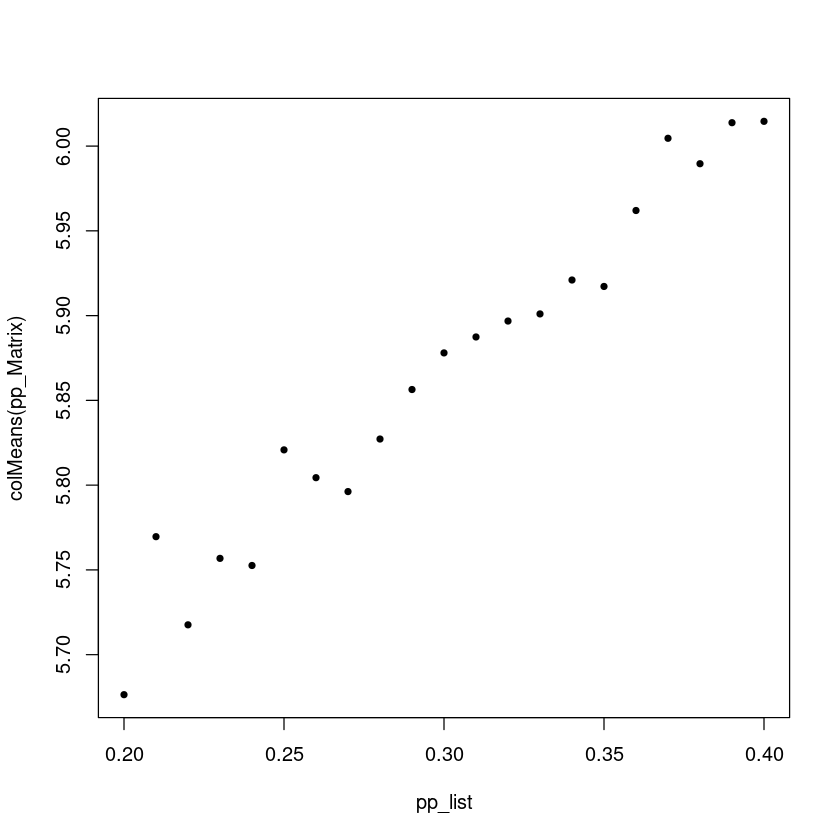

In [198]:
LL = 8
plot(pp_list,colMeans(pp_Matrix),col='black',pch=20)
abline(h=sqrt(3*pi*LL/2))

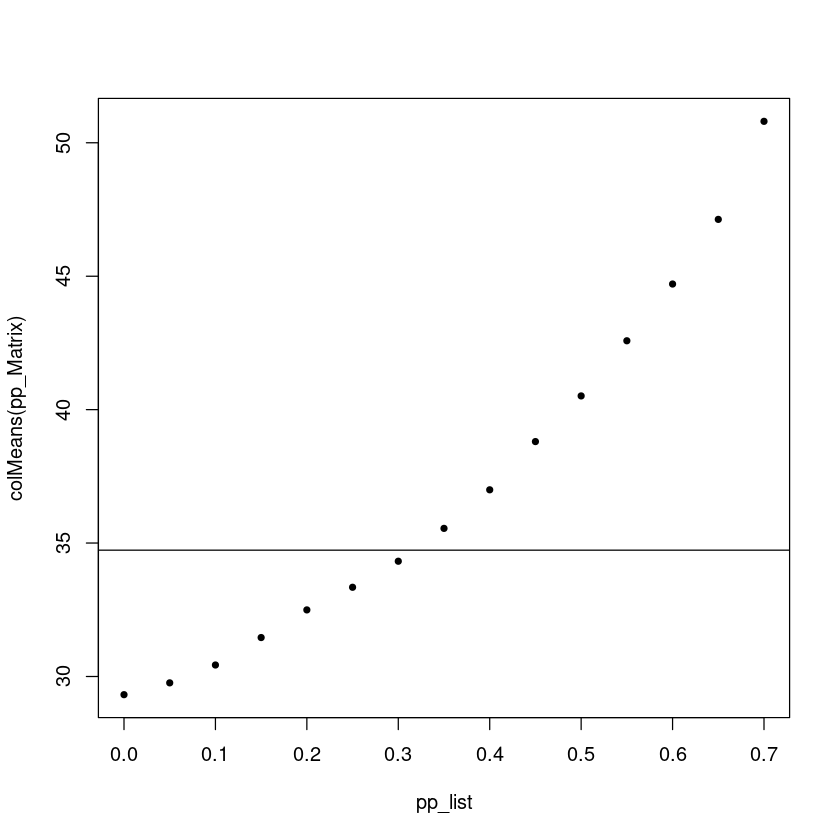

In [184]:
plot(pp_list,colMeans(pp_Matrix),col='black',pch=20)
abline(h=sqrt(3*pi*LL/2))

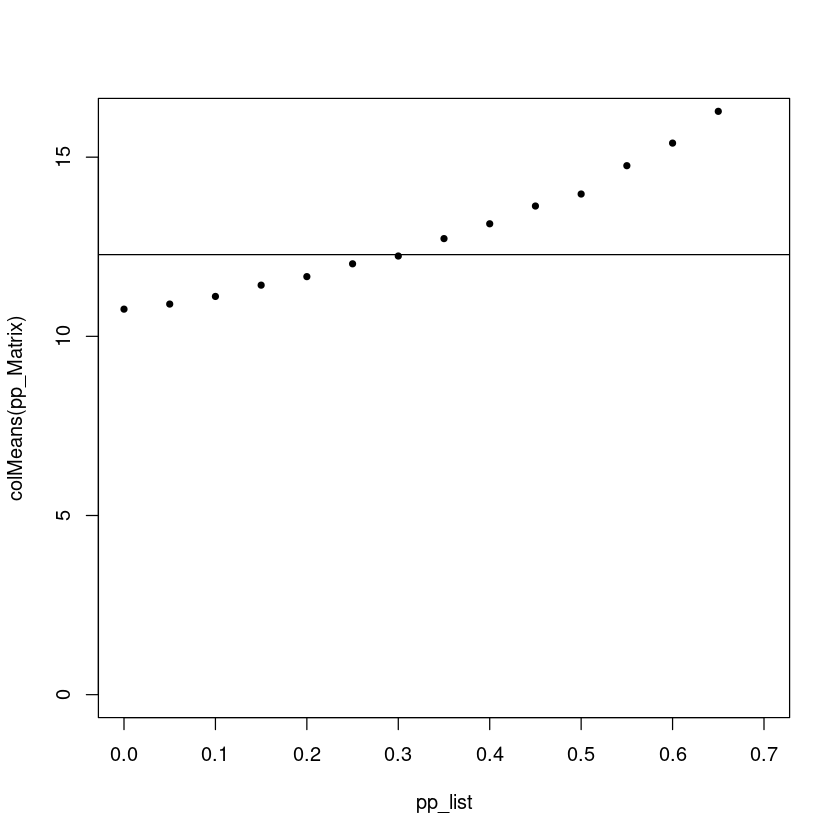

In [175]:
plot(pp_list,colMeans(pp_Matrix),col='black',pch=20,ylim = c(0,16))
abline(h=sqrt(3*pi*LL/2))

In [ ]:
NN = 10000000
ff = 0.0001
Items_List <- c(8,16,32,64,128,256,512)
pp_list <- seq(0,0.7,0.05)
verbose = TRUE
each = 100
starting_item <- 1
start_time = Sys.time()
Repetitions = 5000

Recalled_Matrix <- matrix(0, nrow=Repetitions, ncol=length(Items_List))

for(jj in seq(Repetitions)){
    ii=1
    if(verbose){
        if(jj %% each == 0){
            cat('Repetition:',jj,'  Time:',Sys.time()-start_time,'\n')
            flush.console()
        }
    }
    for(LL in Items_List){
        S_matrix <- NEW_Build_Equivalent_Statistic_SM(LL,ff,NN)
        Recalled_Matrix[jj,ii] <- length(unique(Double_Recall_Process(S_matrix,starting_item)))
        ii <- ii + 1
    }
}

In [53]:
NN = 10000000
ff = 0.0001
Items_List <- c(8,16,32,64,128,256,512)
verbose = TRUE
each = 100
starting_item <- 1
start_time = Sys.time()
Repetitions = 5000

Recalled_Matrix <- matrix(0, nrow=Repetitions, ncol=length(Items_List))

for(jj in seq(Repetitions)){
    ii=1
    if(verbose){
        if(jj %% each == 0){
            cat('Repetition:',jj,'  Time:',Sys.time()-start_time,'\n')
            flush.console()
        }
    }
    for(LL in Items_List){
        S_matrix <- NEW_Build_Equivalent_Statistic_SM(LL,ff,NN)
        Recalled_Matrix[jj,ii] <- length(unique(Double_Recall_Process(S_matrix,starting_item)))
        ii <- ii + 1
    }
}

Repetition: 100   Time: 4.37826 
Repetition: 200   Time: 9.685117 
Repetition: 300   Time: 14.66804 
Repetition: 400   Time: 19.77353 
Repetition: 500   Time: 25.38697 
Repetition: 600   Time: 30.47542 
Repetition: 700   Time: 35.95289 
Repetition: 800   Time: 41.84636 
Repetition: 900   Time: 46.84533 
Repetition: 1000   Time: 52.21619 
Repetition: 1100   Time: 57.5963 
Repetition: 1200   Time: 1.05034 
Repetition: 1300   Time: 1.137866 
Repetition: 1400   Time: 1.224806 
Repetition: 1500   Time: 1.30966 
Repetition: 1600   Time: 1.401582 
Repetition: 1700   Time: 1.487337 
Repetition: 1800   Time: 1.577665 
Repetition: 1900   Time: 1.663733 
Repetition: 2000   Time: 1.752762 
Repetition: 2100   Time: 1.84374 
Repetition: 2200   Time: 1.93529 
Repetition: 2300   Time: 2.029519 
Repetition: 2400   Time: 2.126595 
Repetition: 2500   Time: 2.216584 
Repetition: 2600   Time: 2.304538 
Repetition: 2700   Time: 2.394868 
Repetition: 2800   Time: 2.480419 
Repetition: 2900   Time: 2.569889 


In [54]:
write.table(Recalled_Matrix,'./files/27giu_EQUIVALENT_prova_00001_big.csv',row.names=FALSE,col.names=FALSE)

In [96]:
Items_List <- c(8,16,32,64)
Repetitions <- 200
starting_item <- 1
Recalled_Matrix <- matrix(0, nrow=Repetitions, ncol=length(Items_List))
verbose = TRUE
each = 10

In [146]:
Compute_Recalled_Matrix <- function(Items_List, Repetitions, NN, ff, symmetric, single, verbose, each){
    Recalled_Matrix <- matrix(0, nrow=Repetitions, ncol=length(Items_List))
    start_time <- Sys.time()
    if(!symmetric){
        if(!single){
            cat('ASYMMETRIC \n DOUBLE \n')
            flush.console()
            for(jj in seq(Repetitions)){
                ii=1
                if(verbose){
                    if(jj %% each == 0){
                        cat('Repetition:',jj,'  Time:',Sys.time()-start_time,'\n')
                        flush.console()
                    }
                }
                for(LL in Items_List){
                    ASM <- Build_Asymmetric_Similarity_Matrix(NN,LL,ff,FALSE)
                    Recalled_Matrix[jj,ii] <- length(unique(Double_Recall_Process(ASM,starting_item)))
                    ii <- ii + 1
                }
            }

        }else{
            cat('ASYMMETRIC \n SIMPLE \n')
            flush.console()
            for(jj in seq(Repetitions)){
                ii=1
                if(verbose){
                    if(jj %% each == 0){
                        cat('Repetition:',jj,'  Time:',Sys.time()-start_time,'\n')
                        flush.console()
                    }
                }
                for(LL in Items_List){
                    ASM <- Build_Asymmetric_Similarity_Matrix(NN,LL,ff,FALSE) 
                    Recalled_Matrix[jj,ii] <- length(unique(Simple_Recall_Process(ASM,starting_item)))
                    ii <- ii + 1
                }
            }
        }
    }else{
        if(!single){
            cat('SYMMETRIC \n DOUBLE \n')
            flush.console()
            for(jj in seq(Repetitions)){
                ii=1
                if(verbose){
                    if(jj %% each == 0){
                        cat('Repetition:',jj,'  Time:',Sys.time()-start_time,'\n')
                        flush.console()
                    }
                }
                for(LL in Items_List){
                    ASM <- Build_Symmetric_Similarity_Matrix(NN,LL,ff,FALSE)
                    Recalled_Matrix[jj,ii] <- length(unique(Double_Recall_Process(ASM,starting_item)))
                    ii <- ii + 1
                }
            }

        }else{
            cat('SYMMETRIC \n SIMPLE \n')
            flush.console()
            for(jj in seq(Repetitions)){
                ii=1
                if(verbose){
                    if(jj %% each == 0){
                        cat('Repetition:',jj,'  Time:',Sys.time()-start_time,'\n')
                        flush.console()
                    }
                }
                for(LL in Items_List){
                    ASM <- Build_Symmetric_Similarity_Matrix(NN,LL,ff,FALSE) 
                    Recalled_Matrix[jj,ii] <- length(unique(Simple_Recall_Process(ASM,starting_item)))
                    ii <- ii + 1
                }
            }
        }
    }
    
    end_time <- Sys.time()
    print(end_time - start_time)
    
    return(Recalled_Matrix)
}

In [151]:
Items_List <- c(8,16,32,64,128,256,512)
Repetitions <- 1000
starting_item <- 1
Recalled_Matrix <- matrix(0, nrow=Repetitions, ncol=length(Items_List))
ff = 0.01
NN = 100000
verbose = TRUE
each = 10
symmetric = FALSE
single = TRUE

Recalled_Matrix <- Compute_Recalled_Matrix(Items_List, Repetitions, NN, ff, symmetric, single, verbose, each)
write.table(Recalled_Matrix,'4giu_single_asymmetric_big_001.csv',row.names=FALSE,col.names=FALSE)

ASYMMETRIC 
 SIMPLE 
Repetition: 10   Time: 5.584787 
Repetition: 20   Time: 11.27564 
Repetition: 30   Time: 16.71242 
Repetition: 40   Time: 21.98206 
Repetition: 50   Time: 27.24895 
Repetition: 60   Time: 32.61627 
Repetition: 70   Time: 38.53164 
Repetition: 80   Time: 43.85376 
Repetition: 90   Time: 49.34741 
Repetition: 100   Time: 54.94006 
Repetition: 110   Time: 1.007193 
Repetition: 120   Time: 1.098118 
Repetition: 130   Time: 1.185827 
Repetition: 140   Time: 1.272737 
Repetition: 150   Time: 1.360757 
Repetition: 160   Time: 1.449995 
Repetition: 170   Time: 1.54161 
Repetition: 180   Time: 1.629295 
Repetition: 190   Time: 1.717968 
Repetition: 200   Time: 1.805653 
Repetition: 210   Time: 1.894251 
Repetition: 220   Time: 1.987338 
Repetition: 230   Time: 2.081656 
Repetition: 240   Time: 2.169761 
Repetition: 250   Time: 2.256305 
Repetition: 260   Time: 2.342728 
Repetition: 270   Time: 2.433062 
Repetition: 280   Time: 2.521763 
Repetition: 290   Time: 2.607922 
Rep

In [150]:
single <- FALSE
symmetric <- FALSE
Recalled_Matrix_single<-Compute_Recalled_Matrix(Items_List, Repetitions, NN, ff, symmetric, single, verbose, each)
write.table(Recalled_Matrix,'3giu_doublw_asymmetric_001.csv',row.names=FALSE,col.names=FALSE)

ASYMMETRIC 
 DOUBLE 
Repetition: 50   Time: 12.84308 
Repetition: 100   Time: 25.95719 
Repetition: 150   Time: 39.05564 
Repetition: 200   Time: 52.28729 
Repetition: 250   Time: 1.09188 
Repetition: 300   Time: 1.311303 
Repetition: 350   Time: 1.531345 
Repetition: 400   Time: 1.751149 
Repetition: 450   Time: 1.970458 
Repetition: 500   Time: 2.189448 
Repetition: 550   Time: 2.409185 
Repetition: 600   Time: 2.628485 
Repetition: 650   Time: 2.848939 
Repetition: 700   Time: 3.06902 
Repetition: 750   Time: 3.288055 
Repetition: 800   Time: 3.508512 
Repetition: 850   Time: 3.72766 
Repetition: 900   Time: 3.946273 
Repetition: 950   Time: 4.217822 
Repetition: 1000   Time: 4.453951 
Time difference of 4.458672 hours


In [128]:
symmetric = FALSE
single <- TRUE
Recalled_Matrix_single_asymmetric<-Compute_Recalled_Matrix(Items_List, Repetitions, NN, ff, symmetric, 
                                                           single, verbose, each)

ASYMMETRIC 
 SIMPLE 
Repetition: 10   Time: 5.352055 
Repetition: 20   Time: 11.65932 
Repetition: 30   Time: 17.34756 
Repetition: 40   Time: 23.15372 
Repetition: 50   Time: 29.0552 
Repetition: 60   Time: 34.8138 
Repetition: 70   Time: 40.66349 
Repetition: 80   Time: 46.60028 
Repetition: 90   Time: 52.29153 
Repetition: 100   Time: 58.1815 
Repetition: 110   Time: 1.066798 
Repetition: 120   Time: 1.162511 
Repetition: 130   Time: 1.261671 
Repetition: 140   Time: 1.361404 
Repetition: 150   Time: 1.457679 
Repetition: 160   Time: 1.551513 
Repetition: 170   Time: 1.64834 
Repetition: 180   Time: 1.74212 
Repetition: 190   Time: 1.837979 
Repetition: 200   Time: 1.938497 
Time difference of 1.948285 mins


In [159]:
NN = 100000  # number of neurons
ff = 0.01    # sparsity
starting_item = 1

Repetitions <- 1000
Items_List <- 16*2**(seq(-1,5))

Recalled_Vector <- rep(0,length(Items_List))
Recalled_Matrix <- matrix(0,ncol=length(Items_List),nrow=Repetitions)

In [160]:
start_time <- Sys.time()
for(jj in seq(Repetitions)){
    ii=1
    for(LL in Items_List){
        SM <- Build_Symmetric_Similarity_Matrix(NN,LL,ff,FALSE)           #importantissimo mettere FALSE
        Recalled_Matrix[jj,ii] <- length(unique(Double_Recall_Process(SM,starting_item)))
        ii <- ii + 1
    }
}

end_time <- Sys.time()
print(end_time - start_time)

Time difference of 7.97384 hours


In [161]:
# SAVE THE RECALLED MATRIX
write.table(Recalled_Matrix,'NEW_fsymmetric.csv',row.names=FALSE,col.names=FALSE)